In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [4]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.pyc')

In [5]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 1.66 s, sys: 2.91 s, total: 4.58 s
Wall time: 4.58 s


In [6]:
df.shape

(6582476, 54)

In [7]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 0 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.4 GB


In [8]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [9]:
testx=df[df.index<10000000].drop('target',axis=1)
testx.shape

(1378521, 53)

In [10]:
df=df[df.index>=10000000]

In [11]:
df.shape

(5203955, 54)

In [12]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203955 entries, 10000000 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.1 GB


In [13]:
df=df.loc[np.random.permutation(df.index)]

In [14]:
import gc
gc.collect()

11694

In [15]:
df.head()

market       f_0       f_1       f_2       f_3       f_4  \
id                                                                     
10204444  4.699895  4.434495  4.589514  4.610031  0.340760  1.032539   
10640704  3.981910  4.682021  4.589514  4.622002  2.267699  1.797804   
13528465  5.116831  4.458380  4.715542  4.610031  1.488184  0.000000   
10594702  5.553435  4.434495  4.589514  4.610031  1.586661  0.807616   
13679508  4.389747  4.786207  4.715542  4.622002  1.996116  1.560405   

               f_5  f_6       f_7       f_8    ...     latest_target   count  \
id                                             ...                             
10204444  4.191009  0.0  5.080769  1.077911    ...           -9999.0 -9999.0   
10640704  5.681114  0.0  4.361346  1.372121    ...               7.0     4.0   
13528465  7.289782  0.0  4.896781  1.492079    ...           -9999.0 -9999.0   
10594702  2.859509  0.0  4.523625  1.276678    ...           -9999.0 -9999.0   
13679508  5.681114  0.0  4.679892  1.469020    ...               6.0     2.0   

            freq  latest3_mean  changed_count  latest2_change  latest2_mean  \
id                                                                            
10204444 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0   
10640704     0.8          70.0            2.0             1.0          65.0   
13528465 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0   
10594702 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0   
13679508     1.0       -9999.0            1.0             1.0          55.0   

          mkt_mean  mkt_count  id_count  
id                                       
10204444   5.06667        2.0       8.0  
10640704   7.20833        2.0      10.0  
13528465   5.00000        1.0       1.0  
10594702   5.75000        2.0       7.0  
13679508   5.50000        1.0       2.0  

[5 rows x 54 columns]

In [20]:
trainx=df.drop(['target'],axis=1).values
trainy=df['target'].values

In [21]:
trainx.shape

(5203955, 53)

In [22]:
d_test = xgb.DMatrix(testx.values)

In [18]:
from sklearn.model_selection import KFold

In [26]:
kfold = KFold(5)
models=[]
for train_idx, test_idx in kfold.split(trainx):
    X_train, X_test, y_train, y_test = trainx[train_idx], trainx[test_idx], trainy[train_idx], trainy[test_idx]
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)   

    params = {}
    params['eta'] = 0.2
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'rmse'
    params['max_depth'] = 8
    params['nthread']=8
    params['silent'] = 1
    params['tree_method']='hist'

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40)
    models.append(clf)

[0]	train-rmse:4.20778	valid-rmse:4.20862
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[40]	train-rmse:1.86279	valid-rmse:1.87563
[80]	train-rmse:1.84789	valid-rmse:1.87222
[120]	train-rmse:1.83611	valid-rmse:1.87093
[160]	train-rmse:1.82643	valid-rmse:1.87028
[200]	train-rmse:1.81785	valid-rmse:1.87004
[240]	train-rmse:1.81008	valid-rmse:1.87003
[280]	train-rmse:1.80249	valid-rmse:1.87028
Stopping. Best iteration:
[238]	train-rmse:1.81047	valid-rmse:1.86999

[0]	train-rmse:4.20721	valid-rmse:4.20974
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[40]	train-rmse:1.86123	valid-rmse:1.87846
[80]	train-rmse:1.84678	valid-rmse:1.87544
[120]	train-rmse:1.83511	valid-rmse:1.87404
[160]	train-rmse:1.82642	valid-rmse:1.87359
[200]	train-rmse:1.81751	valid-rmse:1.87321
Stopping. Best iteration:
[188]

# test pred

In [32]:
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [28]:
pred=reduce(lambda u,v:u+v, [clf.predict(d_test) for clf in models])/len(models)

In [33]:
pred.max(),pred.min()

(16.041241, -0.98478591)

In [34]:
pred=clip_pred(pred)

In [35]:
pred.shape

(1378521,)

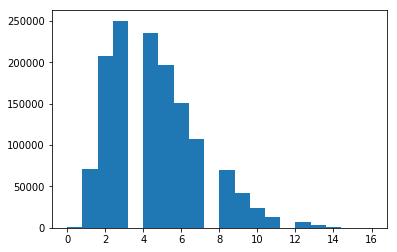

In [36]:
plt.hist(pred,bins=20);

In [37]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

/home/spark/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [38]:
sample_sub.shape

(1378521, 1)

In [39]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [40]:
this_sub=this_sub.loc[sample_sub.index]

In [41]:
this_sub.isnull().sum()

target    0
dtype: int64

In [42]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [43]:
make_submission(this_sub,"../submission/simple_xgb_combined_5fold.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_5fold.csv.7z’: No such file or directory


# test pred2

In [45]:
pred=reduce(lambda u,v:u+v, [clf.predict(d_test) for clf in models])/len(models)

In [46]:
pred=clip_pred(pred)
pred.shape

(1378521,)

In [47]:
pred.mean()

4.5429652504386944

In [48]:
pred=(pred-pred.mean())*1.29+pred.mean()

In [49]:
pred=clip_pred(pred)

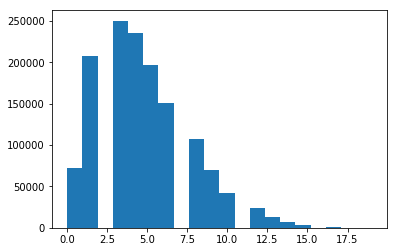

In [50]:
plt.hist(pred,bins=20);

In [51]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [52]:
sample_sub.shape

(1378521, 1)

In [53]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [54]:
this_sub=this_sub.loc[sample_sub.index]

In [55]:
this_sub.isnull().sum()

target    0
dtype: int64

In [56]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [57]:
make_submission(this_sub,"../submission/simple_xgb_combined_5fold_s1.29.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_5fold_s1.29.csv.7z’: No such file or directory
